In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
from sklearn.metrics import mean_squared_error
#import lofo
from sklearn.model_selection import StratifiedGroupKFold
import seaborn as sns
from sklearn.ensemble import VotingRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
#calculates a statistic of a variable by another variable (like getting the average weight(feature 1) for males and female (by sex which is feature 2) )
def stats_by_feat(train,test,feat_to_stat,feat_to_group,func):
    for df in (train,test):
        df[feat_to_stat+feat_to_group+func] = df[feat_to_group].map(df.groupby(feat_to_group)[feat_to_stat].aggregate(func))

In [ ]:
#reading the data
train = pd.read_csv('/content/Train (1).csv')
test = pd.read_csv('/content/Test (1).csv')
train = train[~train['GT_NO2'].isna()]# deleting some points because they don't have the target variable and we can't train the model without target


In [ ]:
len(train)

82051

In [ ]:
train

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.000
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.000
2,ID_V3136Z,1/1/19,RO01,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,31.000
3,ID_KRVZDJ,1/1/19,RO02,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,30.000
4,ID_PR351A,1/1/19,RO03,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,58.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,ID_NCWXIY,31-12-21,X9897,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,39.750
86580,ID_UDQIEE,31-12-21,X9928,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.125
86581,ID_ENDUPX,31-12-21,X9969,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,28.325
86582,ID_3ZBA6C,31-12-21,X9993,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,21.250


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82051 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            82051 non-null  object 
 1   Date                82051 non-null  object 
 2   ID                  82051 non-null  object 
 3   LAT                 82051 non-null  float64
 4   LON                 82051 non-null  float64
 5   Precipitation       82051 non-null  float64
 6   LST                 44457 non-null  float64
 7   AAI                 69933 non-null  float64
 8   CloudFraction       69933 non-null  float64
 9   NO2_strat           69933 non-null  float64
 10  NO2_total           69933 non-null  float64
 11  NO2_trop            48622 non-null  float64
 12  TropopausePressure  69933 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 11.4+ MB


In [ ]:
train['ID'].nunique()

79

In [ ]:
ID = train['ID']

In [ ]:
id = test['ID_Zindi'] #getting the id to use it for the submission file later

In [ ]:
date = pd.to_datetime(train['Date'])

In [ ]:
feautures = ['LST','AAI','NO2_strat','NO2_total','NO2_trop','TropopausePressure']


In [ ]:
for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    df['day'] = df['Date'].dt.day
    # df['day_sin'] = np.sin(df['Date'].dt.day)
    df['dayofyear']= df['Date'].dt.dayofyear
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['LON_sin'] = np.sin(df['LON'])
    df['Lat_sin'] = np.sin(df['LAT'])
    df['no_total_by_no_trop'] = df['NO2_total'] / df['NO2_trop']
    df.drop(columns=['Date','ID_Zindi','ID'],inplace=True)

In [ ]:
for feature in feautures:
    for group in ['day','dayofyear','month','year']:
        for stat in ['mean','std','min','max','var']:
            stats_by_feat(train,test,feature,group,stat)

In [ ]:
train

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
1,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
2,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
3,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
4,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86580,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86581,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86582,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06


In [ ]:
test

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
1,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
2,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
3,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
4,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,45.836941,12.510362,0.000000,282.58,-0.013364,0.000000,0.000032,0.000135,0.000103,13060.46860,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6572,45.582894,8.842165,0.000000,285.12,-0.412887,0.002098,0.000031,0.000201,0.000171,13056.11764,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6573,45.131947,10.015742,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6574,45.186329,9.146666,0.000000,NaN,-1.025128,0.476947,0.000031,0.000751,NaN,13063.22260,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06


In [ ]:
X = train.drop(columns='GT_NO2')
y = train['GT_NO2']

cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
voting = VotingRegressor([('catboost', cat_model),('lgbm',lgbm_model),('xgb',xgb_model)])

model = cat_model
cv = StratifiedGroupKFold(n_splits=7,shuffle=True,random_state=42)

In [ ]:
train

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
1,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
2,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
3,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
4,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86580,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86581,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86582,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06


In [ ]:
import sklearn
train[train.select_dtypes(include=['number']).columns] = train.select_dtypes(include=['number']).astype(float)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler with the default range [0, 1]
scaler = MinMaxScaler()

# Fit and transform the data
train_normalized = scaler.fit_transform(train)

# Convert back to DataFrame
train_normalized = pd.DataFrame(train_normalized, columns=train.columns)

print(train_normalized)

            LAT       LON  Precipitation       LST       AAI  CloudFraction  \
0      0.701412  0.821718       0.000000       NaN  0.739417       0.559117   
1      0.462479  0.805445       0.022507       NaN  0.697923       0.869309   
2      0.125519  0.862536       0.000000       NaN  0.711341       0.674160   
3      0.185879  0.730827       0.008866       NaN  0.706584       0.920053   
4      0.118197  0.792296       0.009414       NaN  0.684002       0.747464   
...         ...       ...            ...       ...       ...            ...   
82046  0.594310  0.212687       0.000000       NaN  0.648825       0.250490   
82047  0.225738  0.339200       0.000000       NaN       NaN            NaN   
82048  0.950752  0.159609       0.000000  0.425777  0.686513       0.000000   
82049  0.195649  0.035693       0.000000       NaN  0.599190       0.399524   
82050  0.623579  0.202243       0.000000       NaN  0.648807       0.250530   

       NO2_strat  NO2_total  NO2_trop  TropopausePr

In [ ]:
from sklearn.impute import KNNImputer

# Initialize the KNNImputer with the desired number of neighbors (e.g., 3)
imputer = KNNImputer(n_neighbors=3)

# Apply KNN imputation on train
imputed_data = imputer.fit_transform(train)

# Convert the result back to a DataFrame
train_imputed = pd.DataFrame(imputed_data, columns=train.columns)

# Display the imputed DataFrame
print(train_imputed)

             LAT        LON  Precipitation         LST       AAI  \
0      45.601585  11.903551       0.000000  281.333333  0.230527   
1      45.371005  11.840830       3.047342  282.200000 -0.074006   
2      45.045825  12.060869       0.000000  281.740000  0.024470   
3      45.104075  11.553241       1.200467  281.333333 -0.010442   
4      45.038758  11.790152       1.274564  280.653333 -0.176178   
...          ...        ...            ...         ...       ...   
82046  45.498227   9.556232       0.000000  282.380000 -0.434350   
82047  45.142541  10.043836       0.000000  279.826667 -0.935496   
82048  45.842207   9.351658       0.000000  284.980000 -0.157753   
82049  45.113503   8.874065       0.000000  279.113333 -0.798636   
82050  45.526473   9.515980       0.000000  283.206667 -0.434482   

       CloudFraction  NO2_strat  NO2_total  NO2_trop  TropopausePressure  ...  \
0           0.559117   0.000024   0.000117  0.000182        14440.821260  ...   
1           0.869309 

In [ ]:
test

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.289376,11.642394,3.277529,NaN,-0.313361,0.771456,0.000024,0.000075,NaN,14440.02819,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
1,45.836941,12.510362,0.000000,NaN,-0.229512,0.398208,0.000023,0.000120,NaN,14434.04790,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
2,45.582894,8.842165,0.000000,282.98,-0.470822,0.153694,0.000023,0.000171,0.000148,14427.42478,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
3,45.131947,10.015742,1.928031,NaN,0.132952,0.756917,0.000024,0.000266,NaN,14443.09006,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
4,45.186329,9.146666,0.000000,NaN,-0.198272,0.678858,0.000023,0.000149,NaN,14440.85840,...,18285.227857,3097.634934,13055.74322,24349.29721,9.595342e+06,16498.992017,3055.948610,9582.273241,24365.70884,9.338822e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,45.836941,12.510362,0.000000,282.58,-0.013364,0.000000,0.000032,0.000135,0.000103,13060.46860,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6572,45.582894,8.842165,0.000000,285.12,-0.412887,0.002098,0.000031,0.000201,0.000171,13056.11764,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6573,45.131947,10.015742,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06
6574,45.186329,9.146666,0.000000,NaN,-1.025128,0.476947,0.000031,0.000751,NaN,13063.22260,...,17316.581743,3280.067951,13055.72560,24352.48246,1.075885e+07,16962.018477,2953.959326,9582.555425,24383.39741,8.725876e+06


In [ ]:
train

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,...,TropopausePressuremonthmean,TropopausePressuremonthstd,TropopausePressuremonthmin,TropopausePressuremonthmax,TropopausePressuremonthvar,TropopausePressureyearmean,TropopausePressureyearstd,TropopausePressureyearmin,TropopausePressureyearmax,TropopausePressureyearvar
0,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
1,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
2,45.045825,12.060869,0.000000,NaN,0.024470,0.674160,0.000024,0.000086,NaN,14437.38294,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
3,45.104075,11.553241,1.200467,NaN,-0.010442,0.920054,0.000024,0.000124,NaN,14440.83831,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
4,45.038758,11.790152,1.274564,NaN,-0.176178,0.747464,0.000024,0.000116,NaN,14438.79037,...,17862.177753,2934.206627,8614.530051,24335.92481,8.609569e+06,16513.857909,3068.616491,8614.530051,24386.94791,9.416407e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86579,45.498227,9.556232,0.000000,NaN,-0.434350,0.250490,0.000032,0.000643,NaN,13063.79770,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86580,45.142541,10.043836,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86581,45.842207,9.351658,0.000000,284.98,-0.157753,0.000000,0.000031,0.000153,0.000122,13050.16499,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06
86582,45.113503,8.874065,0.000000,NaN,-0.798636,0.399524,0.000031,0.000717,NaN,13061.41329,...,16247.738225,2830.819059,9582.290123,24366.72165,8.013537e+06,16946.069572,2944.898050,8614.524651,24410.69675,8.672425e+06


In [ ]:
metrics = []
def validate(trainset,testset,t):
    model.fit(trainset.drop(columns=t),trainset[t])
    pred = model.predict(testset.drop(columns=t))
    score = mean_squared_error(pred,testset[t],squared=False)
    return score

for v_train,v_test in cv.split(train.drop(columns='GT_NO2'),date,groups=ID):
    train_v, test_v= train.iloc[v_train],train.iloc[v_test]
    rmse = validate(train_v,test_v,'GT_NO2')
    metrics.append(rmse)

Streaming output truncated to the last 5000 lines.
4:	learn: 14.3947948	total: 321ms	remaining: 1m 3s
5:	learn: 13.9901993	total: 376ms	remaining: 1m 2s
6:	learn: 13.6138783	total: 435ms	remaining: 1m 1s
7:	learn: 13.2827121	total: 491ms	remaining: 1m
8:	learn: 12.9905225	total: 551ms	remaining: 1m
9:	learn: 12.7246694	total: 612ms	remaining: 1m
10:	learn: 12.4897549	total: 671ms	remaining: 1m
11:	learn: 12.2833793	total: 730ms	remaining: 1m
12:	learn: 12.0859249	total: 781ms	remaining: 59.3s
13:	learn: 11.9052052	total: 835ms	remaining: 58.8s
14:	learn: 11.7493751	total: 891ms	remaining: 58.5s
15:	learn: 11.5943115	total: 956ms	remaining: 58.8s
16:	learn: 11.4599819	total: 1.01s	remaining: 58.3s
17:	learn: 11.3420344	total: 1.06s	remaining: 57.7s
18:	learn: 11.2262745	total: 1.11s	remaining: 57.6s
19:	learn: 11.1341127	total: 1.18s	remaining: 57.6s
20:	learn: 11.0403690	total: 1.23s	remaining: 57.4s
21:	learn: 10.9554220	total: 1.28s	remaining: 57s
22:	learn: 10.8458424	total: 1.36s	r

In [41]:
np.array(metrics).mean()

9.176805977526191

In [42]:
np.array(metrics).std()


1.0552981084670991

In [43]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])

Learning rate set to 0.082149
0:	learn: 16.3775245	total: 81ms	remaining: 1m 20s
1:	learn: 15.7702708	total: 141ms	remaining: 1m 10s
2:	learn: 15.1809210	total: 293ms	remaining: 1m 37s
3:	learn: 14.6682590	total: 433ms	remaining: 1m 47s
4:	learn: 14.2099359	total: 567ms	remaining: 1m 52s
5:	learn: 13.7980593	total: 672ms	remaining: 1m 51s
6:	learn: 13.4369574	total: 829ms	remaining: 1m 57s
7:	learn: 13.1122445	total: 956ms	remaining: 1m 58s
8:	learn: 12.8080928	total: 1.14s	remaining: 2m 5s
9:	learn: 12.5333741	total: 1.3s	remaining: 2m 8s
10:	learn: 12.3088375	total: 1.45s	remaining: 2m 10s
11:	learn: 12.0908669	total: 1.58s	remaining: 2m 10s
12:	learn: 11.9025158	total: 1.71s	remaining: 2m 9s
13:	learn: 11.7252046	total: 1.84s	remaining: 2m 9s
14:	learn: 11.5701447	total: 1.97s	remaining: 2m 9s
15:	learn: 11.4370005	total: 2.11s	remaining: 2m 9s
16:	learn: 11.2884709	total: 2.26s	remaining: 2m 10s
17:	learn: 11.1801901	total: 2.34s	remaining: 2m 7s
18:	learn: 11.0709141	total: 2.43s	

In [49]:
prediction = model.predict(test)

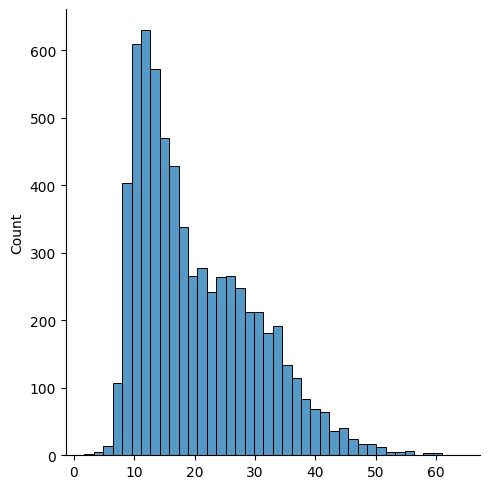

In [45]:
sns.displot(prediction)

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

# Separate features and target variable
X = train.drop(columns=['GT_NO2'])  # Replace 'target_column_name' with the actual name of your target column
y = train['GT_NO2']

# Define your pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),                           # Step 1: Normalize/scale features
    ('feature_selection', SelectKBest(f_classif, k=10)),    # Step 2: Feature selection
    ('classifier', LogisticRegression())                    # Step 3: Model training
])

# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py", line 562, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [46]:
submission = pd.DataFrame({"ID_Zindi":id,'GT_NO2':prediction})

In [48]:
submission.to_csv('submission.csv',index=False)